In [ ]:
import os
import random
import numpy as np
import pandas as pd 
from skimage import io
from skimage import color
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from dask.array.image import imread
# from dask import bag, threaded
from dask.diagnostics import ProgressBar
import cv2
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")



import keras
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import Flatten,Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image 
from keras.layers.normalization import BatchNormalization
from keras import optimizers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/My Drive/deep_learning_project/

/content/drive/.shortcut-targets-by-id/15gKjVs5Brz2wVAZdIJoqScr7ejFRXBo9/deep_learning_project


# read the data

In [ ]:
X_train=np.load('/content/drive/MyDrive/deep_learning_project/X_train.npy')
X_test=np.load('/content/drive/MyDrive/deep_learning_project/X_test.npy')
y_train=np.load('/content/drive/MyDrive/deep_learning_project/y_train.npy')
y_test=np.load('/content/drive/MyDrive/deep_learning_project/y_test.npy')

# load pretrained network

In [ ]:
from keras.layers import Input
from keras.applications.vgg16 import VGG16, preprocess_input

vgg16_input = Input(shape = (224, 224, 3), name = 'Image_input')
model_vgg16_conv = VGG16(weights='imagenet', include_top=False, input_tensor = vgg16_input)
model_vgg16_conv.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# add extra layers before softmax, freeze pretrained layer

In [ ]:
from keras.models import Model


output_vgg16_conv = model_vgg16_conv(vgg16_input)

#Add the fully-connected layers 

x = Flatten(name='flatten')(output_vgg16_conv)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(10, activation='softmax', name='predictions')(x)

vgg16_pretrained = Model()
for layer in vgg16_pretrained.layers[:2]:
    layer.trainable=False
for layer in vgg16_pretrained.layers[2:]:
    layer.trainable=True

vgg16_pretrained_lastlayers = Model(vgg16_input, x)
vgg16_pretrained_lastlayers.summary()

# Compile CNN model
sgd = optimizers.SGD(lr = 0.001)
vgg16_pretrained_lastlayers.compile(loss='categorical_crossentropy',optimizer = sgd,metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 4096)              102764544 
_________________________________________________________________
fc2 (Dense)                  (None, 4096)              16781312  
_________________________________________________________________
predictions (Dense)          (None, 10)                40970     
Total params: 134,301,514
Trainable params: 134,301,514
Non-trainable params: 0
_____________________________________________

In [ ]:
import time

#Record time
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

# train model with data augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping

datagen = ImageDataGenerator(
    height_shift_range=0.5,
    width_shift_range = 0.5,
    zoom_range = 0.5,
    rotation_range=30
        )

data_generator = datagen.flow(X_train, y_train, batch_size = 64)

# Fits the model on batches with real-time data augmentation:
vgg16_model = vgg16_pretrained_lastlayers.fit_generator(data_generator,steps_per_epoch = len(X_train) / 64, callbacks=[time_callback],
                                                            epochs = 60, verbose = 1, validation_data = (X_test, y_test))

Epoch 1/60
269/269 [==============================] - 223s 747ms/step - loss: 2.7143 - accuracy: 0.1178 - val_loss: 2.2409 - val_accuracy: 0.1362
Epoch 2/60
269/269 [==============================] - 191s 707ms/step - loss: 2.2420 - accuracy: 0.1320 - val_loss: 2.1946 - val_accuracy: 0.1926
Epoch 3/60
269/269 [==============================] - 195s 721ms/step - loss: 2.2064 - accuracy: 0.1623 - val_loss: 2.0549 - val_accuracy: 0.2272
Epoch 4/60
269/269 [==============================] - 194s 717ms/step - loss: 2.1300 - accuracy: 0.1958 - val_loss: 1.8760 - val_accuracy: 0.2592
Epoch 5/60
269/269 [==============================] - 191s 707ms/step - loss: 1.9800 - accuracy: 0.2597 - val_loss: 1.6495 - val_accuracy: 0.3382
Epoch 6/60
269/269 [==============================] - 190s 703ms/step - loss: 1.7724 - accuracy: 0.3425 - val_loss: 1.6339 - val_accuracy: 0.3776
Epoch 7/60
269/269 [==============================] - 186s 687ms/step - loss: 1.4540 - accuracy: 0.4829 - val_loss: 1.1632 -

In [ ]:
vgg16_model = pd.DataFrame(vgg16_model.history)
vgg16_model['time'] = time_callback.times
vgg16_model.to_csv('train_final_vgg.csv')

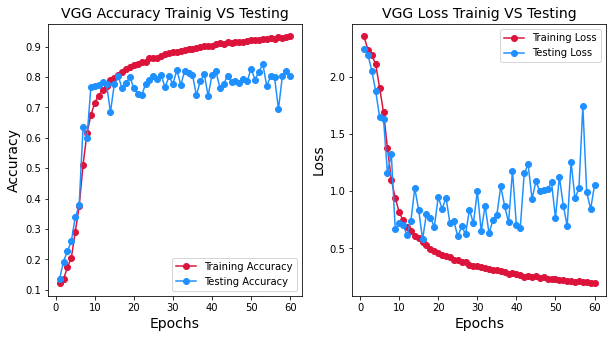

In [ ]:

fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].plot(range(1, len(vgg16_pretrained_lastlayers.history.history['accuracy']) + 1), vgg16_pretrained_lastlayers.history.history['accuracy'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Accuracy')
axes[0].plot(range(1, len(vgg16_pretrained_lastlayers.history.history['val_accuracy']) + 1), vgg16_pretrained_lastlayers.history.history['val_accuracy'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Accuracy')
axes[0].set_xlabel('Epochs', fontsize = 14)
axes[0].set_ylabel('Accuracy',fontsize = 14)
axes[0].set_title('VGG Accuracy Trainig VS Testing', fontsize = 14)
axes[0].legend(loc = 'best')
axes[1].plot(range(1, len(vgg16_pretrained_lastlayers.history.history['loss']) + 1), vgg16_pretrained_lastlayers.history.history['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Loss')
axes[1].plot(range(1, len(vgg16_pretrained_lastlayers.history.history['val_loss']) + 1), vgg16_pretrained_lastlayers.history.history['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Loss')
axes[1].set_xlabel('Epochs', fontsize = 14)
axes[1].set_ylabel('Loss',fontsize = 14)
axes[1].set_title('VGG Loss Trainig VS Testing', fontsize = 14)
axes[1].legend(loc = 'best')